In [1]:
from main import *
from bovw import *
from plotting import *

In [2]:
import os
import random
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

In [4]:
data_train = Dataset(ImageFolder="../data/places_reduced/train")
data_val = Dataset(ImageFolder="../data/places_reduced/val")

len(data_train), len(data_val)

(8700, 2200)

In [5]:
random.shuffle(data_train)
random.shuffle(data_val)

# Dimensionality Reduction Experiments

This notebook explores different dimensionality reduction techniques applied to SIFT descriptors before building the visual vocabulary.

## Methods:

### 1. PCA (Principal Component Analysis)
- **Key Parameter**: `n_components` - number of components to keep
- **Additional**: `whiten` - whether to whiten the components (normalize variance)
- **Use case**: Unsupervised, finds directions of maximum variance

### 2. TruncatedSVD (Singular Value Decomposition)
- **Key Parameter**: `n_components` - number of components to keep
- **Additional**: `n_iter` - number of iterations for randomized solver
- **Use case**: Works with sparse data, similar to PCA but doesn't center data

### 3. LDA (Linear Discriminant Analysis)
- **Key Parameter**: `n_components` - number of components (max: n_classes - 1)
- **Additional**: `solver` - {'svd', 'lsqr', 'eigen'}
- **Use case**: Supervised, maximizes class separability
- **Note**: Requires labels, limited to n_classes - 1 components (10 for 11 classes)

### 4. t-SNE (t-Distributed Stochastic Neighbor Embedding)
- **Key Parameters**: 
  - `n_components` - typically 2 or 3 for visualization
  - `perplexity` - balance between local and global structure (5-50)
  - `learning_rate` - gradient descent step size (10-1000)
- **Use case**: Visualization, preserves local structure
- **Warning**: Very slow, not recommended for high-dimensional embedding in classification pipelines

## Baseline: No Dimensionality Reduction

In [6]:
# Baseline without dimensionality reduction
print("=" * 60)
print("BASELINE: NO DIMENSIONALITY REDUCTION")
print("=" * 60)

baseline_params = {
    "detector_type": "SIFT",
    "codebook_size": 512,
    "detector_kwargs": {"nfeatures": 1000},
    "dimensionality_reduction": None,
}

classifier_params = {
    "kernel": "linear",
    "C": 1.0,
    "class_weight": "balanced",
    "random_state": SEED,
}

baseline_scores = cross_validate_bovw(
    dataset=data_train,
    bovw_kwargs=baseline_params,
    classifier_cls=SVC,
    classifier_kwargs=classifier_params,
    n_splits=5
)

print(f"Baseline -> Train: {baseline_scores.train.accuracy.mean:.4f} ± {baseline_scores.train.accuracy.std:.4f}")
print(f"Baseline -> val:  {baseline_scores.val.accuracy.mean:.4f} ± {baseline_scores.val.accuracy.std:.4f}")

BASELINE: NO DIMENSIONALITY REDUCTION


Phase [Setup]: Extracting the descriptors:  48%|████▊     | 4167/8700 [00:03<00:04, 1080.91it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|█████████▉| 8672/8700 [00:08<00:00, 1012.91it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [01:20<00:00, 16.13s/it]

Baseline -> Train: 0.4752 ± 0.0056
Baseline -> val:  0.3262 ± 0.0083


## Experiment 1: PCA - n_components

In [7]:
# PCA: val different numbers of components
pca_results = {}

print("\n" + "=" * 60)
print("PCA: n_components")
print("=" * 60)

# SIFT descriptors are 128-dimensional
for n_comp in [8, 16, 32, 64, 96, 128]:
    print(f"\n=== valing PCA with n_components={n_comp} ===")
    
    bovw_params = {
        "detector_type": "SIFT",
        "codebook_size": 512,
        "detector_kwargs": {"nfeatures": 1000},
        "dimensionality_reduction": "PCA",
        "dimensionality_reduction_kwargs": {
            "n_components": n_comp,
            "random_state": SEED,
        },
    }
    
    scores = cross_validate_bovw(
        dataset=data_train,
        bovw_kwargs=bovw_params,
        classifier_cls=SVC,
        classifier_kwargs=classifier_params,
        n_splits=5
    )
    
    pca_results[n_comp] = scores
    print(f"n_components={n_comp} -> val Accuracy: {scores.val.accuracy.mean:.4f} ± {scores.val.accuracy.std:.4f}")

print("\n" + "=" * 60)
print("PCA SUMMARY")
print("=" * 60)
for n_comp, result in pca_results.items():
    print(f"n_components={n_comp:3d} -> Train: {result.train.accuracy.mean:.4f} ± {result.train.accuracy.std:.4f} | val {result.val.accuracy.mean:.4f} ± {result.val.accuracy.std:.4f}")


PCA: n_components

=== valing PCA with n_components=8 ===


Phase [Setup]: Extracting the descriptors:  50%|████▉     | 4344/8700 [00:01<00:01, 2634.92it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2635.52it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [01:12<00:00, 14.56s/it]


n_components=8 -> val Accuracy: 0.3098 ± 0.0104

=== valing PCA with n_components=16 ===


Phase [Setup]: Extracting the descriptors:  50%|█████     | 4351/8700 [00:01<00:01, 2691.63it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2652.86it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [01:10<00:00, 14.17s/it]


n_components=16 -> val Accuracy: 0.3189 ± 0.0037

=== valing PCA with n_components=32 ===


Phase [Setup]: Extracting the descriptors:  50%|█████     | 4366/8700 [00:01<00:01, 2696.83it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2667.80it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [01:15<00:00, 15.12s/it]


n_components=32 -> val Accuracy: 0.3257 ± 0.0059

=== valing PCA with n_components=64 ===


Phase [Setup]: Extracting the descriptors:  50%|█████     | 4381/8700 [00:01<00:01, 2729.08it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2688.55it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [01:23<00:00, 16.66s/it]


n_components=64 -> val Accuracy: 0.3258 ± 0.0121

=== valing PCA with n_components=96 ===


Phase [Setup]: Extracting the descriptors:  50%|█████     | 4376/8700 [00:01<00:01, 2710.69it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2682.73it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [01:27<00:00, 17.49s/it]


n_components=96 -> val Accuracy: 0.3249 ± 0.0093

=== valing PCA with n_components=128 ===


Phase [Setup]: Extracting the descriptors:  50%|████▉     | 4348/8700 [00:01<00:01, 2693.45it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2667.81it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [01:31<00:00, 18.25s/it]

n_components=128 -> val Accuracy: 0.3231 ± 0.0065

PCA SUMMARY
n_components=  8 -> Train: 0.4792 ± 0.0035 | val 0.3098 ± 0.0104
n_components= 16 -> Train: 0.4851 ± 0.0040 | val 0.3189 ± 0.0037
n_components= 32 -> Train: 0.4828 ± 0.0039 | val 0.3257 ± 0.0059
n_components= 64 -> Train: 0.4797 ± 0.0011 | val 0.3258 ± 0.0121
n_components= 96 -> Train: 0.4752 ± 0.0056 | val 0.3249 ± 0.0093
n_components=128 -> Train: 0.4762 ± 0.0026 | val 0.3231 ± 0.0065


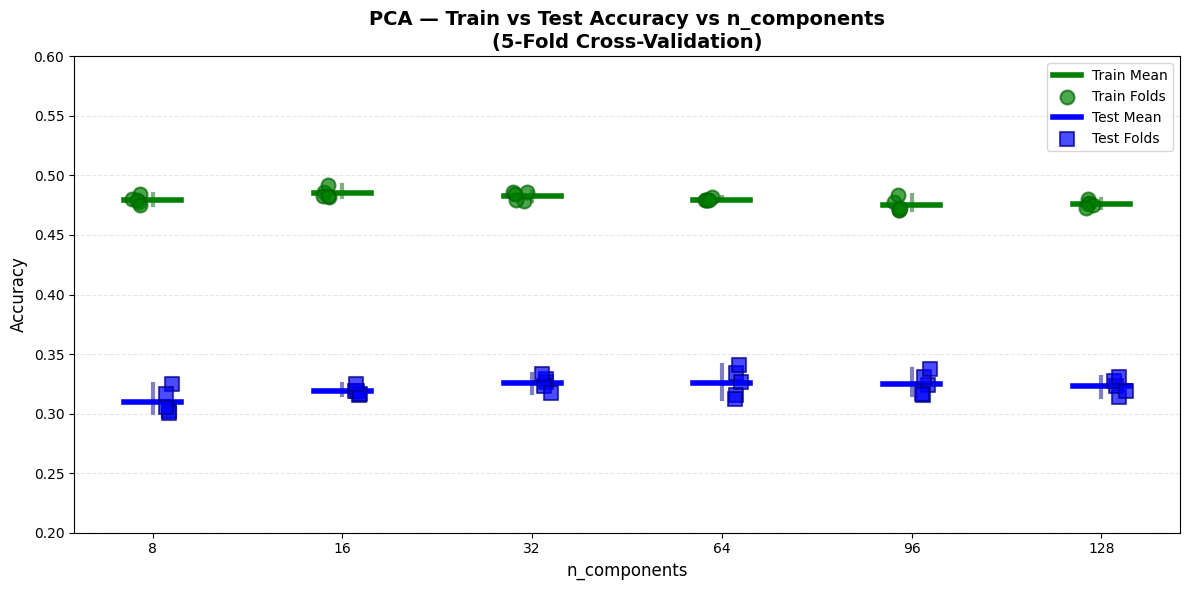

In [8]:
x_vals = [8, 16, 32, 64, 96, 128]
printable_x_vals = [8, 16, 32, 64, 96, 128]
test_vals = [pca_results[key].val.accuracy.all for key in x_vals]
train_vals = [pca_results[key].train.accuracy.all for key in x_vals]
plot_cv_train_test_comparison(printable_x_vals, train_vals, test_vals, "PCA", f"n_components", ylim=(0.2, 0.6))

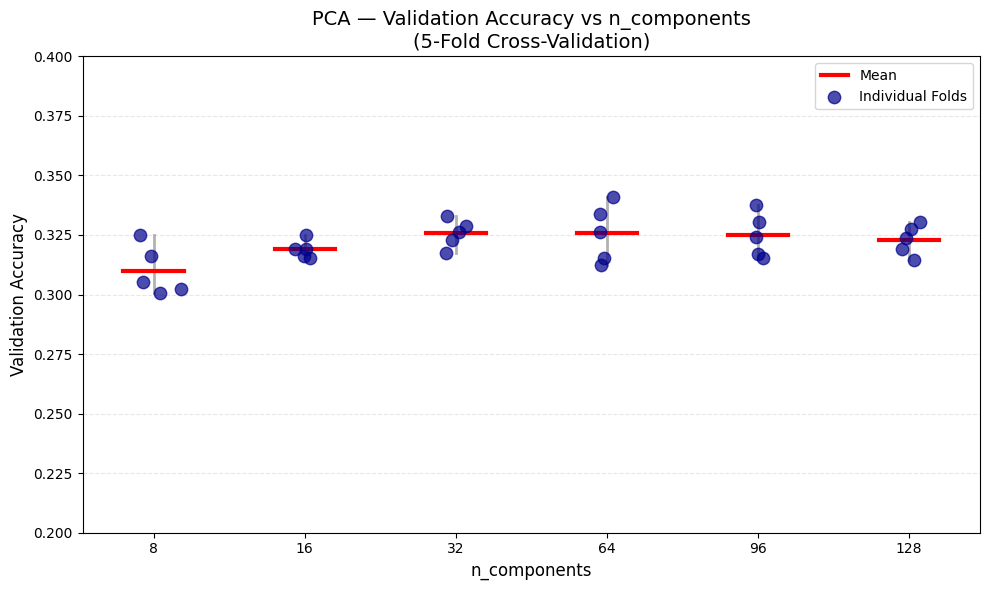

In [9]:
x_vals = [8, 16, 32, 64, 96, 128]
printable_x_vals = [8, 16, 32, 64, 96, 128]
test_vals = [pca_results[key].val.accuracy.all for key in x_vals]
# train_vals = [pca_results[key].train.accuracy.all for key in x_vals]
plot_cv_accuracy_boxplot(printable_x_vals, test_vals, "PCA", f"n_components", ylim=(0.2, 0.4))

## Experiment 2: PCA with Whitening

In [10]:
# PCA: val whitening effect
pca_whitening_results = {}

print("\n" + "=" * 60)
print("PCA: Whitening Effect (n_components=64)")
print("=" * 60)

for whiten in [False, True]:
    print(f"\n=== Testing PCA with whiten={whiten} ===")
    
    bovw_params = {
        "detector_type": "SIFT",
        "codebook_size": 512,
        "detector_kwargs": {"nfeatures": 1000},
        "dimensionality_reduction": "PCA",
        "dimensionality_reduction_kwargs": {
            "n_components": 64,
            "whiten": whiten,
            "random_state": SEED,
        },
    }
    
    scores = cross_validate_bovw(
        dataset=data_train,
        bovw_kwargs=bovw_params,
        classifier_cls=SVC,
        classifier_kwargs=classifier_params,
        n_splits=5
    )
    
    pca_whitening_results[whiten] = scores
    print(f"whiten={whiten} -> Val Accuracy: {scores.val.accuracy.mean:.4f} ± {scores.val.accuracy.std:.4f}")

print("\n" + "=" * 60)
print("PCA WHITENING SUMMARY")
print("=" * 60)
for whiten, result in pca_whitening_results.items():
    print(f"whiten={whiten:5} -> Train: {result.train.accuracy.mean:.4f} ± {result.train.accuracy.std:.4f} | Val: {result.val.accuracy.mean:.4f} ± {result.val.accuracy.std:.4f}")


PCA: Whitening Effect (n_components=64)

=== Testing PCA with whiten=False ===


Phase [Setup]: Extracting the descriptors:  50%|█████     | 4351/8700 [00:01<00:01, 2709.61it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2674.13it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [01:25<00:00, 17.08s/it]


whiten=False -> Val Accuracy: 0.3254 ± 0.0062

=== Testing PCA with whiten=True ===


Phase [Setup]: Extracting the descriptors:  50%|█████     | 4383/8700 [00:01<00:01, 2711.49it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2686.48it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [01:24<00:00, 16.87s/it]

whiten=True -> Val Accuracy: 0.3195 ± 0.0061

PCA WHITENING SUMMARY
whiten=    0 -> Train: 0.4813 ± 0.0048 | Val: 0.3254 ± 0.0062
whiten=    1 -> Train: 0.4675 ± 0.0061 | Val: 0.3195 ± 0.0061


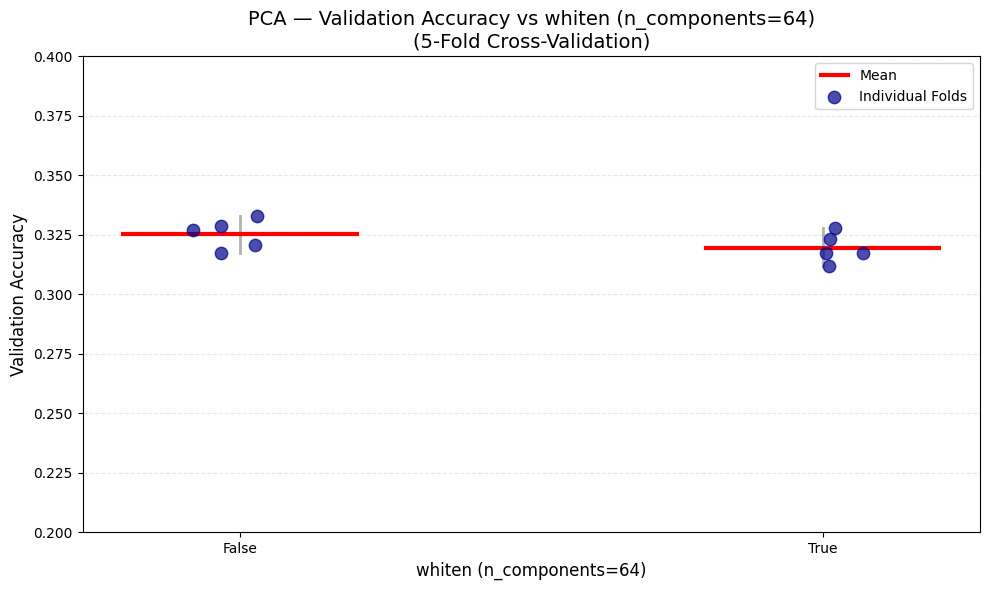

In [11]:
x_vals = [False, True]
printable_x_vals = [False, True]
test_vals = [pca_whitening_results[key].val.accuracy.all for key in x_vals]
# train_vals = [pca_whitening_results[key].train.accuracy.all for key in x_vals]
plot_cv_accuracy_boxplot(printable_x_vals, test_vals, "PCA", f"whiten (n_components=64)", ylim=(0.2, 0.4))

## Experiment 3: SVD - n_components

In [12]:
# SVD: Val different numbers of components
svd_results = {}

print("\n" + "=" * 60)
print("TRUNCATED SVD: n_components")
print("=" * 60)

for n_comp in [8, 16, 32, 64, 96, 127]:  # SVD requires n_components < n_features
    print(f"\n=== Testing SVD with n_components={n_comp} ===")
    
    bovw_params = {
        "detector_type": "SIFT",
        "codebook_size": 512,
        "detector_kwargs": {"nfeatures": 1000},
        "dimensionality_reduction": "SVD",
        "dimensionality_reduction_kwargs": {
            "n_components": n_comp,
            "random_state": SEED,
        },
    }
    
    scores = cross_validate_bovw(
        dataset=data_train,
        bovw_kwargs=bovw_params,
        classifier_cls=SVC,
        classifier_kwargs=classifier_params,
        n_splits=5
    )
    
    svd_results[n_comp] = scores
    print(f"n_components={n_comp} -> Val Accuracy: {scores.val.accuracy.mean:.4f} ± {scores.val.accuracy.std:.4f}")

print("\n" + "=" * 60)
print("SVD SUMMARY")
print("=" * 60)
for n_comp, result in svd_results.items():
    print(f"n_components={n_comp:3d} -> Train: {result.train.accuracy.mean:.4f} ± {result.train.accuracy.std:.4f} | Val: {result.val.accuracy.mean:.4f} ± {result.val.accuracy.std:.4f}")


TRUNCATED SVD: n_components

=== Testing SVD with n_components=8 ===


Phase [Setup]: Extracting the descriptors:  50%|█████     | 4384/8700 [00:01<00:01, 2724.40it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2691.15it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [01:34<00:00, 18.87s/it]


n_components=8 -> Val Accuracy: 0.3089 ± 0.0084

=== Testing SVD with n_components=16 ===


Phase [Setup]: Extracting the descriptors:  50%|█████     | 4366/8700 [00:01<00:01, 2696.02it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2683.56it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [01:43<00:00, 20.65s/it]


n_components=16 -> Val Accuracy: 0.3192 ± 0.0074

=== Testing SVD with n_components=32 ===


Phase [Setup]: Extracting the descriptors:  50%|█████     | 4389/8700 [00:01<00:01, 2735.79it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2690.04it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [02:09<00:00, 25.97s/it]


n_components=32 -> Val Accuracy: 0.3300 ± 0.0083

=== Testing SVD with n_components=64 ===


Phase [Setup]: Extracting the descriptors:  51%|█████     | 4401/8700 [00:01<00:01, 2731.95it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2693.07it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [03:02<00:00, 36.40s/it]


n_components=64 -> Val Accuracy: 0.3290 ± 0.0148

=== Testing SVD with n_components=96 ===


Phase [Setup]: Extracting the descriptors:  50%|█████     | 4391/8700 [00:01<00:01, 2728.50it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2683.50it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [03:58<00:00, 47.69s/it]


n_components=96 -> Val Accuracy: 0.3273 ± 0.0036

=== Testing SVD with n_components=127 ===


Phase [Setup]: Extracting the descriptors:  50%|████▉     | 4337/8700 [00:01<00:01, 2714.23it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2679.24it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [04:58<00:00, 59.78s/it]

n_components=127 -> Val Accuracy: 0.3285 ± 0.0055

SVD SUMMARY
n_components=  8 -> Train: 0.4729 ± 0.0034 | Val: 0.3089 ± 0.0084
n_components= 16 -> Train: 0.4852 ± 0.0048 | Val: 0.3192 ± 0.0074
n_components= 32 -> Train: 0.4800 ± 0.0032 | Val: 0.3300 ± 0.0083
n_components= 64 -> Train: 0.4758 ± 0.0037 | Val: 0.3290 ± 0.0148
n_components= 96 -> Train: 0.4782 ± 0.0027 | Val: 0.3273 ± 0.0036
n_components=127 -> Train: 0.4753 ± 0.0042 | Val: 0.3285 ± 0.0055


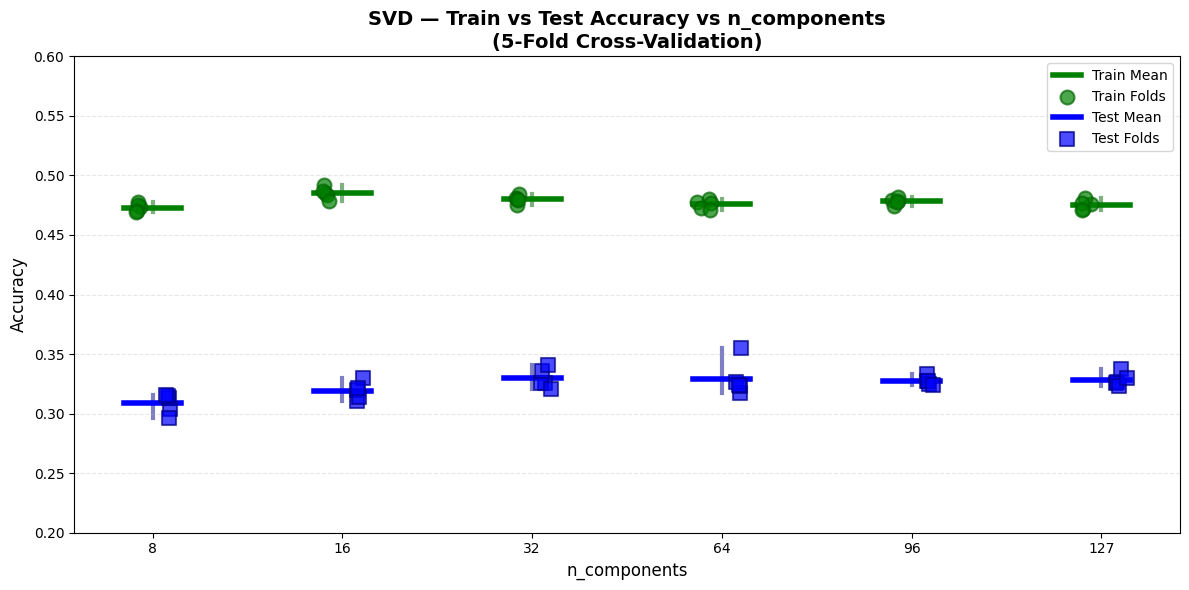

In [13]:
x_vals = [8, 16, 32, 64, 96, 127]
printable_x_vals = [8, 16, 32, 64, 96, 127]
test_vals = [svd_results[key].val.accuracy.all for key in x_vals]
train_vals = [svd_results[key].train.accuracy.all for key in x_vals]
plot_cv_train_test_comparison(printable_x_vals, train_vals, test_vals, "SVD", f"n_components", ylim=(0.2, 0.6))

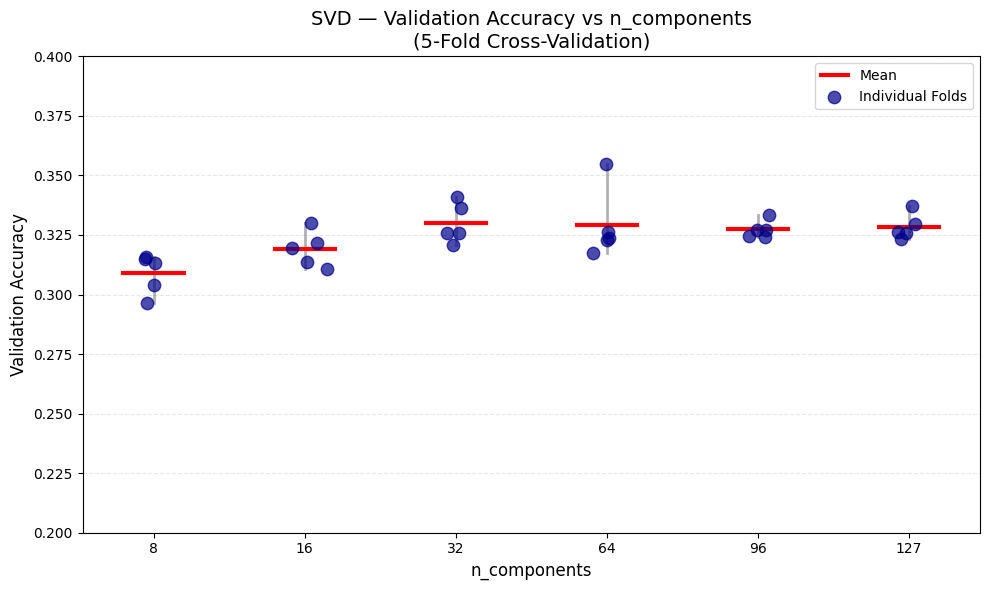

In [14]:
x_vals = [8, 16, 32, 64, 96, 127]
printable_x_vals = [8, 16, 32, 64, 96, 127]
test_vals = [svd_results[key].val.accuracy.all for key in x_vals]
# train_vals = [svd_results[key].train.accuracy.all for key in x_vals]
plot_cv_accuracy_boxplot(printable_x_vals, test_vals, "SVD", f"n_components", ylim=(0.2, 0.4))

In [16]:
# SVD: Val different numbers of components
svd_results = {}

print("\n" + "=" * 60)
print("TRUNCATED SVD: n_components")
print("=" * 60)

for n_comp in [8, 16, 32, 64, 96, 127]:  # SVD requires n_components < n_features
    print(f"\n=== Testing SVD with n_components={n_comp} ===")
    
    bovw_params = {
        "detector_type": "SIFT",
        "codebook_size": 512,
        "detector_kwargs": {"nfeatures": 1000},
        "dimensionality_reduction": "SVD",
        "dimensionality_reduction_kwargs": {
            "n_components": n_comp,
            "random_state": SEED,
        },
    }
    
    scores = cross_validate_bovw(
        dataset=data_train,
        bovw_kwargs=bovw_params,
        classifier_cls=SVC,
        classifier_kwargs=classifier_params,
        n_splits=5
    )
    
    svd_results[n_comp] = scores
    print(f"n_components={n_comp} -> Val Accuracy: {scores.val.accuracy.mean:.4f} ± {scores.val.accuracy.std:.4f}")

print("\n" + "=" * 60)
print("SVD SUMMARY")
print("=" * 60)
for n_comp, result in svd_results.items():
    print(f"n_components={n_comp:3d} -> Train: {result.train.accuracy.mean:.4f} ± {result.train.accuracy.std:.4f} | Val: {result.val.accuracy.mean:.4f} ± {result.val.accuracy.std:.4f}")


TRUNCATED SVD: n_components

=== Testing SVD with n_components=8 ===


Phase [Setup]: Extracting the descriptors:  50%|█████     | 4372/8700 [00:03<00:02, 1897.56it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:06<00:00, 1269.16it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [01:35<00:00, 19.16s/it]


n_components=8 -> Val Accuracy: 0.3070 ± 0.0103

=== Testing SVD with n_components=16 ===


Phase [Setup]: Extracting the descriptors:  50%|█████     | 4355/8700 [00:01<00:01, 2710.37it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2672.90it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [01:48<00:00, 21.61s/it]


n_components=16 -> Val Accuracy: 0.3162 ± 0.0057

=== Testing SVD with n_components=32 ===


Phase [Setup]: Extracting the descriptors:  50%|████▉     | 4340/8700 [00:01<00:01, 2708.55it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2666.78it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [02:12<00:00, 26.46s/it]


n_components=32 -> Val Accuracy: 0.3232 ± 0.0071

=== Testing SVD with n_components=64 ===


Phase [Setup]: Extracting the descriptors:  50%|█████     | 4393/8700 [00:01<00:01, 2740.76it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2697.38it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [03:10<00:00, 38.17s/it]


n_components=64 -> Val Accuracy: 0.3296 ± 0.0110

=== Testing SVD with n_components=96 ===


Phase [Setup]: Extracting the descriptors:  50%|█████     | 4360/8700 [00:01<00:01, 2713.89it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2695.73it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [04:10<00:00, 50.14s/it]


n_components=96 -> Val Accuracy: 0.3286 ± 0.0074

=== Testing SVD with n_components=127 ===


Phase [Setup]: Extracting the descriptors:  50%|█████     | 4368/8700 [00:01<00:01, 2639.14it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2550.98it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [05:11<00:00, 62.38s/it]

n_components=127 -> Val Accuracy: 0.3317 ± 0.0098

SVD SUMMARY
n_components=  8 -> Train: 0.4751 ± 0.0026 | Val: 0.3070 ± 0.0103
n_components= 16 -> Train: 0.4840 ± 0.0088 | Val: 0.3162 ± 0.0057
n_components= 32 -> Train: 0.4817 ± 0.0028 | Val: 0.3232 ± 0.0071
n_components= 64 -> Train: 0.4750 ± 0.0050 | Val: 0.3296 ± 0.0110
n_components= 96 -> Train: 0.4766 ± 0.0020 | Val: 0.3286 ± 0.0074
n_components=127 -> Train: 0.4758 ± 0.0015 | Val: 0.3317 ± 0.0098


## Experiment 4: LDA - n_components and solver

**Note**: LDA is supervised and requires labels. Maximum n_components = n_classes - 1 = 10 for this dataset.

In [15]:
# LDA: Val different numbers of components (max = n_classes - 1 = 10)
lda_results = {}

print("\n" + "=" * 60)
print("LDA: n_components (supervised)")
print("=" * 60)

for n_comp in [5, 8, 10]:
    print(f"\n=== Testing LDA with n_components={n_comp} ===")
    
    bovw_params = {
        "detector_type": "SIFT",
        "codebook_size": 512,
        "detector_kwargs": {"nfeatures": 1000},
        "dimensionality_reduction": "LDA",
        "dimensionality_reduction_kwargs": {
            "n_components": n_comp,
        },
    }
    
    scores = cross_validate_bovw(
        dataset=data_train,
        bovw_kwargs=bovw_params,
        classifier_cls=SVC,
        classifier_kwargs=classifier_params,
        n_splits=5
    )
    
    lda_results[n_comp] = scores
    print(f"n_components={n_comp} -> Val Accuracy: {scores.val.accuracy.mean:.4f} ± {scores.val.accuracy.std:.4f}")

print("\n" + "=" * 60)
print("LDA SUMMARY")
print("=" * 60)
for n_comp, result in lda_results.items():
    print(f"n_components={n_comp:2d} -> Train: {result.train.accuracy.mean:.4f} ± {result.train.accuracy.std:.4f} | Val: {result.val.accuracy.mean:.4f} ± {result.val.accuracy.std:.4f}")


LDA: n_components (supervised)

=== Testing LDA with n_components=5 ===


Phase [Setup]: Extracting the descriptors:  49%|████▉     | 4285/8700 [00:01<00:01, 2694.26it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2669.12it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [04:02<00:00, 48.40s/it]


n_components=5 -> Val Accuracy: 0.3266 ± 0.0089

=== Testing LDA with n_components=8 ===


Phase [Setup]: Extracting the descriptors:  49%|████▉     | 4305/8700 [00:01<00:01, 2677.66it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2597.50it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [04:00<00:00, 48.16s/it]


n_components=8 -> Val Accuracy: 0.3396 ± 0.0107

=== Testing LDA with n_components=10 ===


Phase [Setup]: Extracting the descriptors:  51%|█████     | 4408/8700 [00:01<00:01, 2727.56it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2701.36it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [04:04<00:00, 48.87s/it]

n_components=10 -> Val Accuracy: 0.3394 ± 0.0106

LDA SUMMARY
n_components= 5 -> Train: 0.4822 ± 0.0041 | Val: 0.3266 ± 0.0089
n_components= 8 -> Train: 0.5007 ± 0.0060 | Val: 0.3396 ± 0.0107
n_components=10 -> Train: 0.5050 ± 0.0055 | Val: 0.3394 ± 0.0106


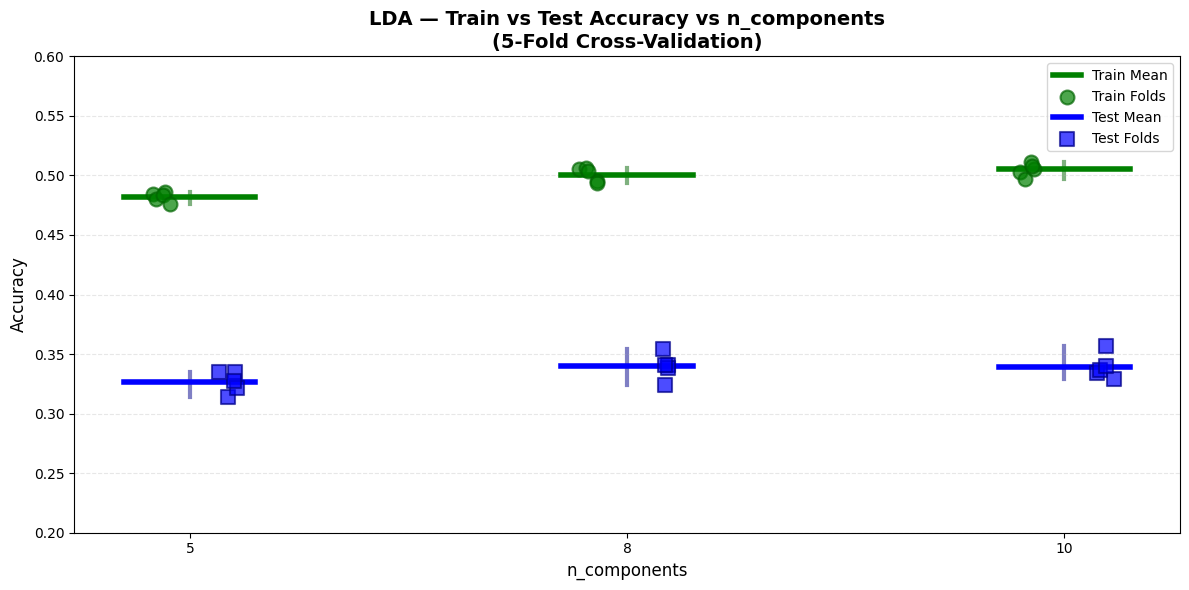

In [16]:
x_vals = [5, 8, 10]
printable_x_vals = [5, 8, 10]
test_vals = [lda_results[key].val.accuracy.all for key in x_vals]
train_vals = [lda_results[key].train.accuracy.all for key in x_vals]
plot_cv_train_test_comparison(printable_x_vals, train_vals, test_vals, "LDA", f"n_components", ylim=(0.2, 0.6))

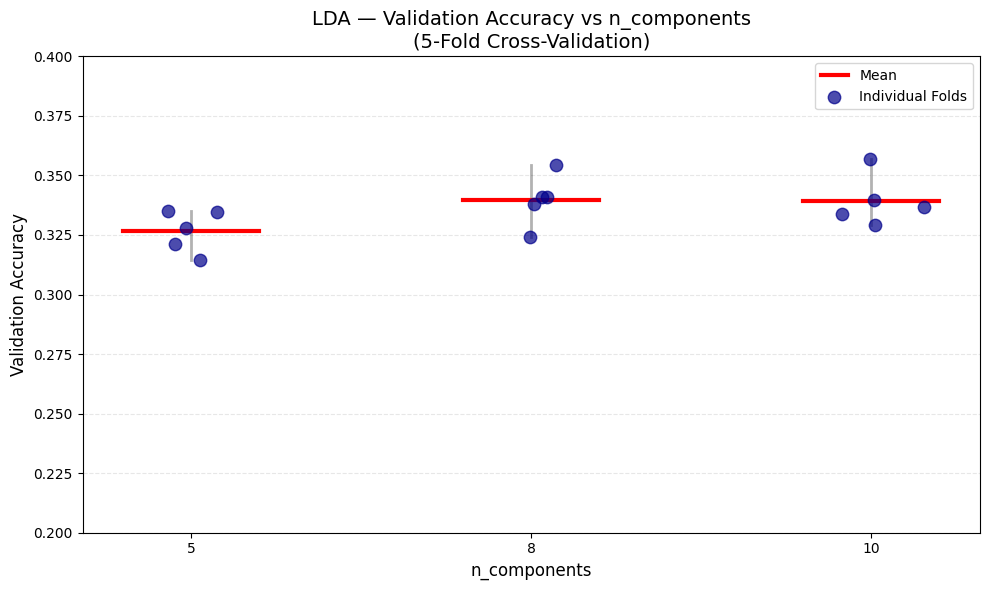

In [17]:
x_vals = [5, 8, 10]
printable_x_vals = [5, 8, 10]
test_vals = [lda_results[key].val.accuracy.all for key in x_vals]
# train_vals = [lda_results[key].train.accuracy.all for key in x_vals]
plot_cv_accuracy_boxplot(printable_x_vals, test_vals, "LDA", f"n_components", ylim=(0.2, 0.4))

## Experiment 5: LDA Solvers

In [ ]:
# LDA: Val different solvers
lda_solver_results = {}

print("\n" + "=" * 60)
print("LDA: Solver Comparison (n_components=10)")
print("=" * 60)

for solver in ['svd', 'eigen']:
    print(f"\n=== Testing LDA with solver={solver} ===")
    
    bovw_params = {
        "detector_type": "SIFT",
        "codebook_size": 512,
        "detector_kwargs": {"nfeatures": 1000},
        "dimensionality_reduction": "LDA",
        "dimensionality_reduction_kwargs": {
            "n_components": 10,
            "solver": solver,
        },
    }
    
    scores = cross_validate_bovw(
        dataset=data_train,
        bovw_kwargs=bovw_params,
        classifier_cls=SVC,
        classifier_kwargs=classifier_params,
        n_splits=5
    )
    
    lda_solver_results[solver] = scores
    print(f"solver={solver} -> Val Accuracy: {scores.val.accuracy.mean:.4f} ± {scores.val.accuracy.std:.4f}")

print("\n" + "=" * 60)
print("LDA SOLVER SUMMARY")
print("=" * 60)
for solver, result in lda_solver_results.items():
    print(f"solver={solver:5s} -> Train: {result.train.accuracy.mean:.4f} ± {result.train.accuracy.std:.4f} | Val: {result.val.accuracy.mean:.4f} ± {result.val.accuracy.std:.4f}")


LDA: Solver Comparison (n_components=10)

=== Testing LDA with solver=svd ===


Phase [Setup]: Extracting the descriptors:  52%|█████▏    | 4507/8700 [00:02<00:01, 2558.81it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2332.20it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [04:08<00:00, 49.70s/it]


solver=svd -> Test Accuracy: 0.3426 ± 0.0118

=== Testing LDA with solver=lsqr ===


Phase [Setup]: Extracting the descriptors:  50%|████▉     | 4316/8700 [00:01<00:01, 2646.22it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:03<00:00, 2642.70it/s]


Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


  0%|          | 0/5 [00:04<?, ?it/s]


NotImplementedError: transform not implemented for 'lsqr' solver (use 'svd' or 'eigen').

## Final Comparison: All Methods

In [ ]:
# Summary comparison of all dimensionality reduction methods
print("\n" + "=" * 60)
print("FINAL COMPARISON: ALL DIMENSIONALITY REDUCTION METHODS")
print("=" * 60)

comparison = {
    "Baseline (None)": baseline_scores,
    "PCA (n=64)": pca_results[64],
    "SVD (n=64)": svd_results[64],
    "LDA (n=10)": lda_results[10],
}

for method_name, result in comparison.items():
    print(f"{method_name:20s} -> Train: {result.train.accuracy.mean:.4f} ± {result.train.accuracy.std:.4f} | Val: {result.val.accuracy.mean:.4f} ± {result.val.accuracy.std:.4f}")

# Find best method
best_method = max(comparison.items(), key=lambda x: x[1].val.accuracy.mean)
print(f"\nBest method: {best_method[0]} with val accuracy {best_method[1].val.accuracy.mean:.4f}")